'pwd' is not recognized as an internal or external command,
operable program or batch file.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB
The ratings dataset has 162541 unique users
The ratings dataset has 59047 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
<class 'pandas.core.frame.DataFrame'>
Index: 10290 entries, 1 to 58800
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              10290 non-null  object 
 1   mean_rating        10290 non-null  float64
 2   number_of_ratings  10290 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 321.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24440317 entries, 0 to 244403

MemoryError: Unable to allocate 12.5 GiB for an array with shape (10290, 162540) and data type float64

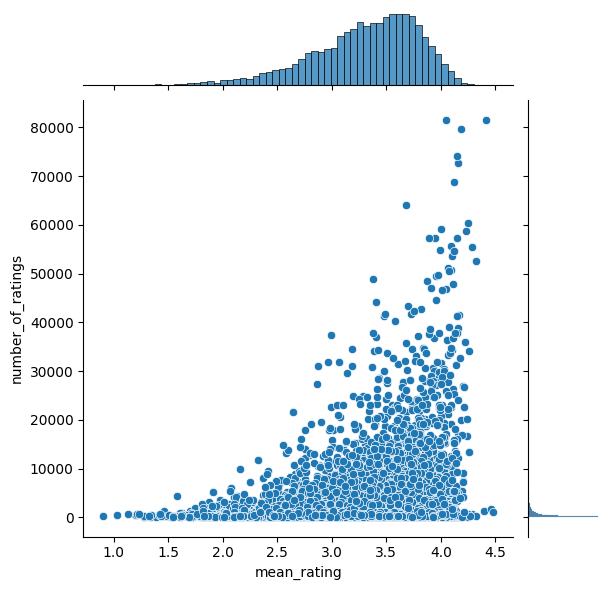

In [6]:
###### Step 1: Import Python Libraries

# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity


###### Step 2: Download And Read In Data

# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Change directory
import os
# os.chdir("drive/My Drive/contents/recommendation_system")

ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

# # Print out the current directory
# !pwd

# Read in data
# ratings=pd.read_csv('ml-latest-small/ratings.csv')

# Take a look at the data
ratings.head()

# Get the dataset information
ratings.info()

# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

# Read in data
# movies = pd.read_csv('ml-latest-small/movies.csv')

# Take a look at the data
movies.head()

# Merge ratings and movies datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')

# Take a look at the data
df.head()


###### Step 3: Exploratory Data Analysis (EDA)

# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()

# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))


###### Step 4: Create User-Movie Matrix

# Create user-item matrix
matrix = df_GT100.pivot_table(index='userId', columns='title', values='rating')
matrix.head()


###### Step 5: Data Normalization

# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()


###### Step 6: Identify Similar Users

# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)


###### Step 7: Narrow Down Item Pool

# Remove movies that have been watched
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_movies


###### Step 8: Recommend Items

# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])

# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Select top m movies
m = 10
ranked_item_score.head(m)


###### Step 9: Predict Scores (Optional)

# Average rating for the picked user
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]

# Print the average movie rating for user 1
print(f'The average movie rating for user {picked_userid} is {avg_rating:.2f}')

# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating

# Take a look at the data
ranked_item_score.head(m)


